In [1]:
!pip install --upgrade git+https://github.com/terrier-org/pyterrier.git#egg=python-terrier
!pip install --upgrade git+https://github.com/Georgetown-IR-Lab/OpenNIR

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/terrier-org/pyterrier.git to /tmp/pip-install-t93923cq/python-terrier_a2998679b250463186ab97291c573a2b
  Running command git clone -q https://github.com/terrier-org/pyterrier.git /tmp/pip-install-t93923cq/python-terrier_a2998679b250463186ab97291c573a2b
  Resolved https://github.com/terrier-org/pyterrier.git to commit 134d80342a746c438c4deef5d30f1d1462ebab7a
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/Georgetown-IR-Lab/OpenNIR to /tmp/pip-req-build-0gz4_b41
  Running command git clone -q https://github.com/Georgetown-IR-Lab/OpenNIR /tmp/pip-req-build-0gz4_b41
  Resolved https://github.com/Georgetown-IR-Lab/OpenNIR to commit 88a4679372f471a04d284a99404ffce2b7a1dc49


In [2]:
import os
os.environ["JAVA_HOME"] = "/sw/pkgs/arc/openjdk/jdk-18.0.1.1"
os.environ['JVM_PATH']='/sw/pkgs/arc/openjdk/jdk-18.0.1.1/lib/server/libjvm.so'


import pyterrier as pt
if not pt.started():
    pt.init(tqdm='notebook')

import pandas as pd
import onir_pt
import numpy as np
import math

PyTerrier 0.9.1 has loaded Terrier 5.7 (built by craigm on 2022-11-10 18:30) and terrier-helper 0.0.7

No etc/terrier.properties, using terrier.default.properties for bootstrap configuration.


Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [3]:
dataset = pd.read_csv('./dataset_full.csv')
query = pd.read_csv('./query.csv')
qrels = pd.read_csv('./qrels.csv')


query['qid']=query['qid'].astype('str')
qrels['qid']=qrels['qid'].astype('str')


combined_list = []
for i in range(len(dataset)):
    combined_list.append(dataset['Description'][i] + dataset['pos_review_content'][i])
dataset['combined'] = combined_list
dataset['revised_title']=dataset['pos_review_title'].apply(lambda row: row[0:int(len(row)/2)])
dataset = dataset.fillna('None')

In [4]:
!rm -rf ./proj_file
index_path = './proj_file'

indexer = pt.DFIndexer(index_path, overwrite=True, blocks=True)
index_ref = indexer.index(dataset['combined'], dataset['docno'])
index = pt.IndexFactory.of(index_ref)

In [5]:
print(index.getCollectionStatistics().toString())

Number of documents: 13571
Number of terms: 65000
Number of postings: 4111997
Number of fields: 0
Number of tokens: 7330675
Field names: []
Positions:   true



# Query Expansion

In [6]:
bm25 = pt.BatchRetrieve(index,wmodel="BM25")
qe = pt.rewrite.Bo1QueryExpansion(index)
sdm = pt.rewrite.SequentialDependence()

In [7]:
from pyterrier.measures import *
pt.Experiment(
    [bm25%50, (bm25>>qe>>bm25)%50, (sdm>>bm25)%50],
    query,
    qrels,
    names=['BM25', 'Bo1 QE','SDM'],
    eval_metrics=[AP(rel=3), P(rel=3)@50, "ndcg", "ndcg_cut_5", "ndcg_cut_10", 'mrt']
)

,name,AP(rel=3),P(rel=3)@50,ndcg,ndcg_cut_5,ndcg_cut_10,mrt
0,BM25,0.505849,0.570,0.740277,0.667947,0.684460,26.543634
1,Bo1 QE,0.539878,0.600,0.763332,0.680896,0.695181,60.029948
2,SDM,0.512819,0.568,0.742006,0.692826,0.699737,40.336547


# Learning to rank


Since 60% train data, 20% valid data, 20% test data is reasonable. The total topics is 40.
Therefore, we set Train set to be 24,  Test and Valid to be 8.

In [8]:
SEED=13
from sklearn.model_selection import train_test_split
tr_va_data,test_data=train_test_split(query,test_size=8,random_state=SEED)
train_data,valid_data=train_test_split(tr_va_data,test_size=8,random_state=SEED)

## Part 1 Pair-wise BERT reranker (Store into checkpoint)

In [9]:
import gc, torch
gc.collect()
torch.cuda.empty_cache()

In [10]:
VBERT_CACHE_NAME = 'trained_bert55.tar.gz'

if not os.path.exists(VBERT_CACHE_NAME):
    vbert = onir_pt.reranker('vanilla_transformer', 'bert', text_field='revised_title', vocab_config={'train': True})
    pipeline1 = (pt.BatchRetrieve(index, wmodel="BM25") %55) >> pt.apply.generic(lambda df: df.merge(dataset,on='docno')) >> vbert
    pipeline1.fit(train_data, qrels, valid_data, qrels)
    onir_pt.reranker.to_checkpoint(vbert, VBERT_CACHE_NAME) #Save trained BERT into file

else:
    vbert=onir_pt.reranker.from_checkpoint(VBERT_CACHE_NAME, text_field='revised_title')

config file not found: config


In [11]:
from pyterrier.measures import *
pt.Experiment(
    [(bm25%50), ((bm25%50) >> pt.apply.generic(lambda df: df.merge(dataset,on='docno')) >> vbert)%50],
    test_data,
    qrels,
    names=['BM25', 'BM25 >> VBERT'],
    baseline=0,
    eval_metrics=[AP(rel=3), P(rel=3)@10, "ndcg", "ndcg_cut_5", "ndcg_cut_10", 'mrt']
)

[2022-12-17 21:24:33,374][onir_pt][DEBUG] using GPU (deterministic)
[2022-12-17 21:24:43,612][onir_pt][DEBUG] [starting] batches


batches:   0%|          | 0/100 s<?, ?it/s]

[2022-12-17 21:25:21,910][onir_pt][DEBUG] [finished] batches: [38.30s] [100it] [ 2.61it/s]


,name,ndcg,ndcg_cut_5,ndcg_cut_10,AP(rel=3),P(rel=3)@10,mrt,ndcg +,ndcg -,ndcg p-value,...,ndcg_cut_5 p-value,ndcg_cut_10 +,ndcg_cut_10 -,ndcg_cut_10 p-value,AP(rel=3) +,AP(rel=3) -,AP(rel=3) p-value,P(rel=3)@10 +,P(rel=3)@10 -,P(rel=3)@10 p-value
0,BM25,0.778395,0.658551,0.698940,0.527218,0.6250,23.860467,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BM25 >> VBERT,0.744747,0.576042,0.611716,0.464210,0.5375,6222.305281,3.0,5.0,0.157504,...,0.372333,3.0,5.0,0.275448,2.0,6.0,0.214372,2.0,4.0,0.421693


## Part 2: Sentiment analysis on negative review (Store into cache)

In [12]:
import json
SENTIMENT_CACHE_NAME = 'dataset_sentiment.json'

if not os.path.exists(SENTIMENT_CACHE_NAME):
    import nltk
    from nltk.sentiment import SentimentIntensityAnalyzer
    nltk.download([
            "names",
            "stopwords",
            "averaged_perceptron_tagger",
            "vader_lexicon",
            "punkt",
    ])
    sia = SentimentIntensityAnalyzer()
    senti = dataset['neg_review_content'].apply(lambda x: sia.polarity_scores(x)['neg']).tolist()
    fw = open(SENTIMENT_CACHE_NAME,"w")
    fw.write(json.dumps(senti))
    fw.close() 
else:
    cache_file = open(SENTIMENT_CACHE_NAME, 'r')
    cache_content = cache_file.read()
    senti = json.loads(cache_content)
    cache_file.close()

## Part 3: Sentence Transformer model

In [13]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

## Part 4: Feature analysis

### ltr_feats1: Only 5 basic feature

In [14]:
ltr_feats1 = ((bm25>>qe>>bm25)%50) >>   pt.apply.generic(lambda df: df.merge(dataset,on='docno'))>> (
        pt.transformer.IdentityTransformer()
        ** # new feature: TF-IDF indicator
        pt.BatchRetrieve(index, wmodel="TF_IDF")
        ** #new feature: review number
        (pt.apply.doc_score(lambda row: math.log(row['review_num'])))
        ** #new feature: overall rate
        (pt.apply.doc_score(lambda row: row['overall_rate']))
        **# new feature: positive review title length
        (pt.apply.doc_score(lambda row: len(row['pos_review_title']) ))
    )

import fastrank

qrels['label'] = qrels['label'].apply(lambda x: float(x))
train_request = fastrank.TrainRequest.coordinate_ascent()

params = train_request.params
params.init_random = True
params.normalize = True
params.seed = 1234567

ca_pipe1 = ltr_feats1 >> pt.ltr.apply_learned_model(train_request, form='fastrank')

%time ca_pipe1.fit(train_data, qrels)

---------------------------
Training starts...
---------------------------
[+] Random restart #1/5...
[+] Random restart #3/5...
[+] Random restart #2/5...
[+] Random restart #4/5...
[+] Random restart #5/5...
Shuffle features and optimize!
----------------------------------------
   0|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   2|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
Shuffle features and optimize!
----------------------------------------
   3|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   4|Feature         |   Weight|     NDCG
----------------------------------------
----------------------------------------
   1|Feature         |   Weight|     NDCG
----------------------------------------
   0|4         

### ltr_feats2: ltr_feats1 + VBERT

In [15]:
ltr_feats2 = ((bm25>>qe>>bm25)%50) >>   pt.apply.generic(lambda df: df.merge(dataset,on='docno'))>> (
        pt.transformer.IdentityTransformer()
        ** # new feature: TF-IDF indicator
        pt.BatchRetrieve(index, wmodel="TF_IDF")
        ** #new feature: review number
        (pt.apply.doc_score(lambda row: math.log(row['review_num'])))
        ** #new feature: overall rate
        (pt.apply.doc_score(lambda row: row['overall_rate']))
        **# new feature: positive review title length
        (pt.apply.doc_score(lambda row: len(row['pos_review_title']) ))
        **
        (vbert)
    )

import fastrank

qrels['label'] = qrels['label'].apply(lambda x: float(x))
train_request = fastrank.TrainRequest.coordinate_ascent()

params = train_request.params
params.init_random = True
params.normalize = True
params.seed = 1234567

ca_pipe2 = ltr_feats2 >> pt.ltr.apply_learned_model(train_request, form='fastrank')

%time ca_pipe2.fit(train_data, qrels)

[2022-12-17 21:25:27,718][onir_pt][DEBUG] using GPU (deterministic)
[2022-12-17 21:25:27,722][onir_pt][DEBUG] [starting] batches


batches:   0%|          | 0/300 s<?, ?it/s]

[2022-12-17 21:25:35,709][onir_pt][DEBUG] [finished] batches: [7.99s] [300it] [37.57it/s]
---------------------------
Training starts...
---------------------------
[+] Random restart #1/5...
[+] Random restart #3/5...
[+] Random restart #2/5...
[+] Random restart #4/5...
[+] Random restart #5/5...
Shuffle features and optimize!
----------------------------------------
   2|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   3|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   1|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   0|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   4|Fea

### ltr_feats3: ltr_feats1 + Sentiment

In [16]:
ltr_feats3 = ((bm25>>qe>>bm25)%50) >>   pt.apply.generic(lambda df: df.merge(dataset,on='docno'))>> (
        pt.transformer.IdentityTransformer()
        ** # new feature: TF-IDF indicator
        pt.BatchRetrieve(index, wmodel="TF_IDF")
        ** #new feature: review number
        (pt.apply.doc_score(lambda row: math.log(row['review_num'])))
        ** #new feature: overall rate
        (pt.apply.doc_score(lambda row: row['overall_rate']))
        **# new feature: positive review title length
        (pt.apply.doc_score(lambda row: len(row['pos_review_title']) ))
        ** # negative relevance
        (pt.text.scorer(body_attr="neg_review_content", wmodel='BM25') >> (pt.apply.doc_score(lambda row: row['score']* senti[int(row['docid'])])))
    )

import fastrank

qrels['label'] = qrels['label'].apply(lambda x: float(x))
train_request = fastrank.TrainRequest.coordinate_ascent()

params = train_request.params
params.init_random = True
params.normalize = True
params.seed = 1234567

ca_pipe3 = ltr_feats3 >> pt.ltr.apply_learned_model(train_request, form='fastrank')

%time ca_pipe3.fit(train_data, qrels)

---------------------------
Training starts...
---------------------------
[+] Random restart #1/5...
[+] Random restart #3/5...
[+] Random restart #2/5...
[+] Random restart #4/5...
[+] Random restart #5/5...
Shuffle features and optimize!
----------------------------------------
   0|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   1|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   3|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   4|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   2|Feature         |   Weight|     NDCG
----------------------------------------
   0|0         

### ltr_feats4: ltr_feats1 + Sentence transformer&Cosine similarity

In [17]:
ltr_feats4 = ((bm25>>qe>>bm25)%50) >>   pt.apply.generic(lambda df: df.merge(dataset,on='docno'))>> (
        pt.transformer.IdentityTransformer()
        ** # new feature: TF-IDF indicator
        pt.BatchRetrieve(index, wmodel="TF_IDF")
        ** #new feature: review number
        (pt.apply.doc_score(lambda row: math.log(row['review_num'])))
        ** #new feature: overall rate
        (pt.apply.doc_score(lambda row: row['overall_rate']))
        **# new feature: positive review title length
        (pt.apply.doc_score(lambda row: len(row['pos_review_title']) ))
        **
        (pt.apply.doc_score(lambda row: float(util.pytorch_cos_sim(model.encode(row["query_0"], convert_to_tensor=True), model.encode(row["Description"], convert_to_tensor=True)))))
    )

import fastrank

qrels['label'] = qrels['label'].apply(lambda x: float(x))
train_request = fastrank.TrainRequest.coordinate_ascent()

params = train_request.params
params.init_random = True
params.normalize = True
params.seed = 1234567

ca_pipe4 = ltr_feats4 >> pt.ltr.apply_learned_model(train_request, form='fastrank')

%time ca_pipe4.fit(train_data, qrels)

---------------------------
Training starts...
---------------------------
[+] Random restart #1/5...
[+] Random restart #3/5...
[+] Random restart #2/5...
[+] Random restart #4/5...
[+] Random restart #5/5...
Shuffle features and optimize!
----------------------------------------
   0|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   2|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   1|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   3|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   4|Feature         |   Weight|     NDCG
----------------------------------------
   0|0         

### ltr_feats_all: All 8 features pipeline

In [18]:
ltr_feats_all = ((bm25>>qe>>bm25)%50) >>   pt.apply.generic(lambda df: df.merge(dataset,on='docno'))>> (
        pt.transformer.IdentityTransformer()
        ** # new feature: TF-IDF indicator
        pt.BatchRetrieve(index, wmodel="TF_IDF")
        ** #new feature: review number
        (pt.apply.doc_score(lambda row: math.log(row['review_num'])))
        ** #new feature: overall rate
        (pt.apply.doc_score(lambda row: row['overall_rate']))
        **# new feature: positive review title length
        (pt.apply.doc_score(lambda row: len(row['pos_review_title']) ))
        ** # new feature: state in query
        (pt.apply.doc_score(lambda row: int( row["query_0"] is not None and (row ['State'].lower()in row["query_0"].lower()) )))
        ** # negative relevance
        (pt.text.scorer(body_attr="neg_review_content", wmodel='BM25') >> (pt.apply.doc_score(lambda row: row['score']* senti[int(row['docid'])])))
        **
        (pt.apply.doc_score(lambda row: float(util.pytorch_cos_sim(model.encode(row["query_0"], convert_to_tensor=True), model.encode(row["Description"], convert_to_tensor=True)))))
        **
        (vbert)
    )

myfnames=["BM25", "TF-IDF",'revienum','overall_rate','pos_reviewLen', 'State', 'Sentiment of neg_review', 'Sentense transformer', 'VBERT']

import fastrank

qrels['label'] = qrels['label'].apply(lambda x: float(x))
train_request = fastrank.TrainRequest.coordinate_ascent()

params = train_request.params
params.init_random = True
params.normalize = True
params.seed = 1234567

ca_pipe_all = ltr_feats_all >> pt.ltr.apply_learned_model(train_request, form='fastrank')

%time ca_pipe_all.fit(train_data, qrels)

[2022-12-17 21:26:19,026][onir_pt][DEBUG] using GPU (deterministic)
[2022-12-17 21:26:19,032][onir_pt][DEBUG] [starting] batches


batches:   0%|          | 0/300 s<?, ?it/s]

[2022-12-17 21:26:27,040][onir_pt][DEBUG] [finished] batches: [8.01s] [300it] [37.47it/s]
---------------------------
Training starts...
---------------------------
[+] Random restart #1/5...
[+] Random restart #3/5...
[+] Random restart #2/5...
[+] Random restart #4/5...
[+] Random restart #5/5...
Shuffle features and optimize!
----------------------------------------
   0|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   2|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   1|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   3|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   4|Fea

## Evaluation

In [19]:
qrels['label'] = qrels['label'].apply(lambda x: int(x))
from pyterrier.measures import *
pt.Experiment(
    [pt.BatchRetrieve(index,wmodel='BM25')%50, ca_pipe1, ca_pipe2,
     ca_pipe3, ca_pipe4, ca_pipe_all],
    test_data,
    qrels,
    names=['BM25(Baseline)','pipe_basic(5 feature)', 'pipe_basic+BERT', 'pipe_basic+Sentiment', 'pipe_basic+SentenceTransform', 'pipe_baic+ALL features'],
    eval_metrics=[AP(rel=3), P(rel=3)@10, "ndcg", "ndcg_cut_5", "ndcg_cut_10", 'mrt']
)

[2022-12-17 21:26:29,141][onir_pt][DEBUG] using GPU (deterministic)
[2022-12-17 21:26:29,145][onir_pt][DEBUG] [starting] batches


batches:   0%|          | 0/100 s<?, ?it/s]

[2022-12-17 21:26:31,590][onir_pt][DEBUG] [finished] batches: [2.44s] [100it] [40.92it/s]
[2022-12-17 21:26:46,246][onir_pt][DEBUG] using GPU (deterministic)
[2022-12-17 21:26:46,250][onir_pt][DEBUG] [starting] batches


batches:   0%|          | 0/100 s<?, ?it/s]

[2022-12-17 21:26:48,692][onir_pt][DEBUG] [finished] batches: [2.44s] [100it] [40.95it/s]


,name,AP(rel=3),P(rel=3)@10,ndcg,ndcg_cut_5,ndcg_cut_10,mrt
0,BM25(Baseline),0.527218,0.6250,0.778395,0.658551,0.698940,21.557884
1,pipe_basic(5 feature),0.567570,0.6500,0.796696,0.704020,0.720504,80.271579
2,pipe_basic+BERT,0.587849,0.7000,0.807200,0.775564,0.748184,385.148373
3,pipe_basic+Sentiment,0.586948,0.6750,0.807075,0.749246,0.742542,132.022660
4,pipe_basic+SentenceTransform,0.566731,0.6875,0.806556,0.768570,0.757627,829.645116
5,pipe_baic+ALL features,0.577326,0.7000,0.810882,0.765056,0.763536,1182.609474


## What features matters in ltr_feats_all

In [20]:
pt.Experiment(
    [ltr_feats_all >> pt.ltr.feature_to_score(i) for i in range(len(myfnames))],
    test_data,
    qrels, 
    names=myfnames,
    eval_metrics=[AP(rel=3), P(rel=3)@10, "ndcg", "ndcg_cut_5", "ndcg_cut_10", 'mrt'])

[2022-12-17 21:26:55,722][onir_pt][DEBUG] using GPU (deterministic)
[2022-12-17 21:26:55,729][onir_pt][DEBUG] [starting] batches


batches:   0%|          | 0/100 s<?, ?it/s]

[2022-12-17 21:26:58,155][onir_pt][DEBUG] [finished] batches: [2.43s] [100it] [41.23it/s]
[2022-12-17 21:27:05,174][onir_pt][DEBUG] using GPU (deterministic)
[2022-12-17 21:27:05,179][onir_pt][DEBUG] [starting] batches


batches:   0%|          | 0/100 s<?, ?it/s]

[2022-12-17 21:27:07,607][onir_pt][DEBUG] [finished] batches: [2.43s] [100it] [41.21it/s]
[2022-12-17 21:27:14,570][onir_pt][DEBUG] using GPU (deterministic)
[2022-12-17 21:27:14,575][onir_pt][DEBUG] [starting] batches


batches:   0%|          | 0/100 s<?, ?it/s]

[2022-12-17 21:27:16,999][onir_pt][DEBUG] [finished] batches: [2.42s] [100it] [41.27it/s]
[2022-12-17 21:27:23,967][onir_pt][DEBUG] using GPU (deterministic)
[2022-12-17 21:27:23,971][onir_pt][DEBUG] [starting] batches


batches:   0%|          | 0/100 s<?, ?it/s]

[2022-12-17 21:27:26,391][onir_pt][DEBUG] [finished] batches: [2.42s] [100it] [41.34it/s]
[2022-12-17 21:27:33,352][onir_pt][DEBUG] using GPU (deterministic)
[2022-12-17 21:27:33,356][onir_pt][DEBUG] [starting] batches


batches:   0%|          | 0/100 s<?, ?it/s]

[2022-12-17 21:27:35,775][onir_pt][DEBUG] [finished] batches: [2.42s] [100it] [41.35it/s]
[2022-12-17 21:27:42,701][onir_pt][DEBUG] using GPU (deterministic)
[2022-12-17 21:27:42,706][onir_pt][DEBUG] [starting] batches


batches:   0%|          | 0/100 s<?, ?it/s]

[2022-12-17 21:27:45,129][onir_pt][DEBUG] [finished] batches: [2.42s] [100it] [41.28it/s]
[2022-12-17 21:27:53,319][onir_pt][DEBUG] using GPU (deterministic)
[2022-12-17 21:27:53,325][onir_pt][DEBUG] [starting] batches


batches:   0%|          | 0/100 s<?, ?it/s]

[2022-12-17 21:27:56,146][onir_pt][DEBUG] [finished] batches: [2.82s] [100it] [35.47it/s]
[2022-12-17 21:28:04,527][onir_pt][DEBUG] using GPU (deterministic)
[2022-12-17 21:28:04,532][onir_pt][DEBUG] [starting] batches


batches:   0%|          | 0/100 s<?, ?it/s]

[2022-12-17 21:28:07,358][onir_pt][DEBUG] [finished] batches: [2.82s] [100it] [35.41it/s]
[2022-12-17 21:28:15,568][onir_pt][DEBUG] using GPU (deterministic)
[2022-12-17 21:28:15,572][onir_pt][DEBUG] [starting] batches


batches:   0%|          | 0/100 s<?, ?it/s]

[2022-12-17 21:28:18,012][onir_pt][DEBUG] [finished] batches: [2.44s] [100it] [41.00it/s]


,name,AP(rel=3),P(rel=3)@10,ndcg,ndcg_cut_5,ndcg_cut_10,mrt
0,BM25,0.510320,0.6250,0.780160,0.654993,0.684473,1179.999167
1,TF-IDF,0.573852,0.6500,0.799244,0.708145,0.718224,1180.269699
2,revienum,0.480125,0.5000,0.761884,0.583944,0.605530,1173.429900
3,overall_rate,0.525961,0.6250,0.773886,0.606003,0.659752,1173.073315
4,pos_reviewLen,0.547511,0.6750,0.789753,0.718946,0.710416,1172.590542
5,State,0.508380,0.4875,0.768920,0.600673,0.600827,1168.038791
6,Sentiment of neg_review,0.499994,0.6000,0.763875,0.622076,0.635395,1380.136042
7,Sentense transformer,0.534188,0.6750,0.786907,0.698437,0.707197,1401.549737
8,VBERT,0.484065,0.5500,0.761977,0.596652,0.624728,1326.604957


## Feature Weight comparison

In [21]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=400, verbose=1, random_state=SEED, n_jobs=2)

rf_pipe = ltr_feats_all >> pt.ltr.apply_learned_model(rf)

%time rf_pipe.fit(train_data, qrels)

[2022-12-17 21:28:38,888][onir_pt][DEBUG] using GPU (deterministic)
[2022-12-17 21:28:38,893][onir_pt][DEBUG] [starting] batches


batches:   0%|          | 0/300 s<?, ?it/s]

[2022-12-17 21:28:46,933][onir_pt][DEBUG] [finished] batches: [8.04s] [300it] [37.32it/s]


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    1.0s finished


CPU times: user 30.6 s, sys: 275 ms, total: 30.9 s
Wall time: 29.9 s


/tmp/ipykernel_79976/1284213065.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


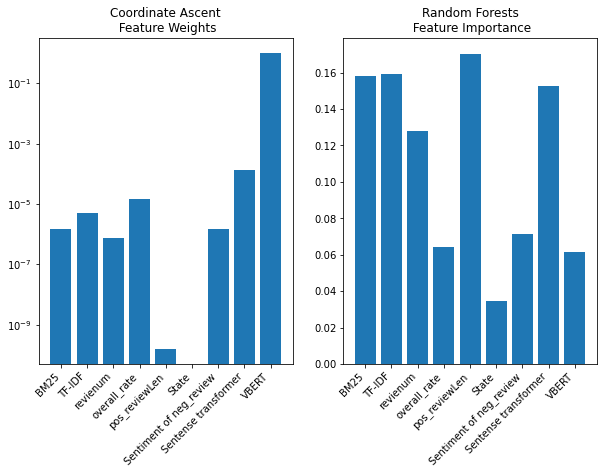

In [22]:
myfnames=["BM25", "TF-IDF",'revienum','overall_rate','pos_reviewLen', 'State', 'Sentiment of neg_review', 'Sentense transformer', 'VBERT']
%matplotlib inline
import matplotlib.pyplot as plt, numpy as np

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 6))

ax0.bar(np.arange(len(myfnames)), [abs(x) for x in ca_pipe_all[1].model.to_dict()['Linear']['weights']])
ax0.set_xticks(np.arange(len(myfnames)))
ax0.set_xticklabels(myfnames, rotation=45, ha='right')
ax0.set_title("Coordinate Ascent\n Feature Weights")
ax0.set_yscale('log')

ax1.bar(np.arange(len(myfnames)), rf.feature_importances_)
ax1.set_xticks(np.arange(len(myfnames)))
ax1.set_xticklabels(myfnames, rotation=45, ha='right')
ax1.set_title("Random Forests\n Feature Importance")

fig.show()

# Interaction!

In [30]:
x = input("Input a query: ")
df = ca_pipe_all.search(x)
for idx in df.index:
    result_id = int(df['docid'][idx])
    print('\n')
    print('\n')
    print('Rank: '+str(df['rank'][idx]))
    print('Document '+ str(result_id) + ': '+ dataset['Name'][result_id], dataset['State'][result_id])
    print("Rate: "+ str(dataset['overall_rate'][result_id]), "Review Number: "+ str(dataset['review_num'][result_id]))
    print(dataset['url'][result_id])
    print(dataset['Description'][result_id])
    

Input a query: hiking in Michigan
[2022-12-17 21:38:51,388][onir_pt][DEBUG] using GPU (deterministic)
[2022-12-17 21:38:51,392][onir_pt][DEBUG] [starting] batches


batches:   0%|          | 0/13 s<?, ?it/s]

[2022-12-17 21:38:51,702][onir_pt][DEBUG] [finished] batches: s] [13it] [42.13it/s]




Rank: 0
Document 8934: Oval Beach, Saugatuck, Michigan, One of the Best Beaches and Shorelines in the World Michigan
Rate: 4.5 Review Number: 1085.0
https://www.tripadvisor.com/Attraction_Review-g42683-d142430-Reviews-or20-Oval_Beach-Saugatuck_Allegan_County_Michigan.html
Oval Beach in Saugatuck, Michigan has been rated by Cond, Nast Traveler as one of the 25 best shorelines in the world, while MTV has it ranked as one of the country's top five beaches. National Geographic Traveler takes it a step further, rating it as one of the top two freshwater beaches in the country. Those rankings come thanks to the area's combination of towering sand dunes, white sand beach, beautiful views, seclusion, and services, such as life guards and concessions. Oval beach can best be reached via North America's only hand-pulled chain ferry boat, which crosses the Kalamazoo River from nearby Saugatuck. A climb of 282 s